In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
from myrmsprop import MyRmsprop
%matplotlib inline
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
train_data = np.load("train_type4_data.npy",allow_pickle=True)

test_data = np.load("test_type4_data.npy",allow_pickle=True)

In [3]:
mosaic_list_of_images = train_data[0]["mosaic_list"]
mosaic_label = train_data[0]["mosaic_label"]
fore_idx = train_data[0]["fore_idx"]


test_mosaic_list_of_images = test_data[0]["mosaic_list"]
test_mosaic_label = test_data[0]["mosaic_label"]
test_fore_idx = test_data[0]["fore_idx"]

In [4]:
class MosaicDataset1(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label,fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] , self.fore_idx[idx]

In [5]:
batch = 3000
train_dataset = MosaicDataset1(mosaic_list_of_images, mosaic_label, fore_idx)
train_loader = DataLoader( train_dataset,batch_size= batch ,shuffle=False)
#batch = 2000
#test_dataset = MosaicDataset1(test_mosaic_list_of_images, test_mosaic_label, test_fore_idx)
#test_loader = DataLoader(test_dataset,batch_size= batch ,shuffle=False)

In [6]:
n_batches = 3000//batch
bg = []
for i in range(n_batches):
  torch.manual_seed(i)
  betag = torch.randn(3000,9)#torch.ones((250,9))/9
  bg.append( betag.requires_grad_() )

In [7]:
len(bg)

1

In [8]:
#H = np.zeros((27000,27000))
for i, data in enumerate(train_loader, 0):
  print(i) # only one batch
  inputs,_,_ = data
  inputs = torch.reshape(inputs,(27000,2))
  dis = torch.cdist(inputs,inputs)**2
  gamma = -1/torch.median(dis)
  print(gamma)
  H = torch.exp(gamma*dis)


0
tensor(-0.0948)


In [9]:
H.shape

torch.Size([27000, 27000])

In [10]:
class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    self.linear1 = nn.Linear(2,100)
    self.linear2 = nn.Linear(100,3)

  def forward(self,x):
    x = F.relu(self.linear1(x))
    x = self.linear2(x)
    return x

In [11]:
torch.manual_seed(1234)
what_net = Module2().double()

what_net.load_state_dict(torch.load("type4_what_net.pt"))
what_net = what_net.to("cuda")

In [12]:
def attn_avg(x,beta):
  y = torch.zeros([batch,2], dtype=torch.float64)
  y = y.to("cuda")
  alpha = F.softmax(beta,dim=1)   # alphas
  #print(alpha[0],x[0,:])
  for i in range(9):            
    alpha1 = alpha[:,i]      
    y = y + torch.mul(alpha1[:,None],x[:,i])
  return y,alpha


In [13]:
def calculate_attn_loss(dataloader,what,criter):
  what.eval()
  r_loss = 0
  alphas = []
  lbls = []
  pred = []
  fidices = []
  correct = 0
  tot = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels,fidx= data
      lbls.append(labels)
      fidices.append(fidx)
      inputs = inputs.double()
      beta = bg[i]  # beta for ith batch
      inputs, labels,beta = inputs.to("cuda"),labels.to("cuda"),beta.to("cuda")
      avg,alpha = attn_avg(inputs,beta)
      alpha = alpha.to("cuda")
      outputs = what(avg)
      _, predicted = torch.max(outputs.data, 1)
      correct += sum(predicted == labels)
      tot += len(predicted)
      pred.append(predicted.cpu().numpy())
      alphas.append(alpha.cpu().numpy())
      loss = criter(outputs, labels)
      r_loss += loss.item()
  alphas = np.concatenate(alphas,axis=0)
  pred = np.concatenate(pred,axis=0)
  lbls = np.concatenate(lbls,axis=0)
  fidices = np.concatenate(fidices,axis=0)
  #print(alphas.shape,pred.shape,lbls.shape,fidices.shape) 
  analysis = analyse_data(alphas,lbls,pred,fidices)
  return r_loss/(i+1),analysis,correct.item(),tot,correct.item()/tot

In [14]:
# for param in what_net.parameters():
#     param.requires_grad = False

In [15]:

def analyse_data(alphas,lbls,predicted,f_idx):
    '''
       analysis data is created here
    '''
    batch = len(predicted)
    amth,alth,ftpt,ffpt,ftpf,ffpf = 0,0,0,0,0,0
    for j in range (batch):
      focus = np.argmax(alphas[j])
      if(alphas[j][focus] >= 0.5):
        amth +=1
      else:
        alth +=1
      if(focus == f_idx[j] and predicted[j] == lbls[j]):
        ftpt += 1
      elif(focus != f_idx[j] and predicted[j] == lbls[j]):
        ffpt +=1
      elif(focus == f_idx[j] and predicted[j] != lbls[j]):
        ftpf +=1
      elif(focus != f_idx[j] and predicted[j] != lbls[j]):
        ffpf +=1
    #print(sum(predicted==lbls),ftpt+ffpt)
    return [ftpt,ffpt,ftpf,ffpf,amth,alth]

In [16]:
optim1 = []
H= H.to("cpu")
for i in range(n_batches):
  optim1.append(MyRmsprop([bg[i]],H=H,lr=1))
  #optim1.append(optim.RMSprop([bg[i]],lr=0.1))

In [17]:
# instantiate optimizer
optimizer_what = optim.RMSprop(what_net.parameters(), lr=0.001)#, momentum=0.9)#,nesterov=True)


 


criterion = nn.CrossEntropyLoss()
acti = []
analysis_data_tr = []
analysis_data_tst = []
loss_curi_tr = []
loss_curi_tst = []
epochs = 200


# calculate zeroth epoch loss and FTPT values
running_loss,anlys_data,correct,total,accuracy = calculate_attn_loss(train_loader,what_net,criterion)
print('training epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(0,running_loss,correct,total,accuracy)) 
loss_curi_tr.append(running_loss)
analysis_data_tr.append(anlys_data)




# training starts 
for epoch in range(epochs): # loop over the dataset multiple times
  ep_lossi = []
  running_loss = 0.0
  what_net.train()
  for i, data in enumerate(train_loader, 0):
    # get the inputs
    inputs, labels,_  = data
    inputs = inputs.double()
    beta = bg[i] # alpha for ith batch
    #print(labels)
    inputs, labels,beta = inputs.to("cuda"),labels.to("cuda"),beta.to("cuda")
        
    # zero the parameter gradients
    optimizer_what.zero_grad()
    optim1[i].zero_grad()
      
    # forward + backward + optimize
    avg,alpha = attn_avg(inputs,beta)
    outputs = what_net(avg)     
    loss = criterion(outputs, labels)

    # print statistics
    running_loss += loss.item()
    #alpha.retain_grad()
    loss.backward(retain_graph=False)
    optimizer_what.step()
    optim1[i].step()


  running_loss_tr,anls_data,correct,total,accuracy = calculate_attn_loss(train_loader,what_net,criterion)
  analysis_data_tr.append(anls_data)
  loss_curi_tr.append(running_loss_tr)   #loss per epoch
  print('training epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(epoch+1,running_loss_tr,correct,total,accuracy)) 


  
  if running_loss_tr<=0.08:
    break
print('Finished Training run ')
analysis_data_tr = np.array(analysis_data_tr)



training epoch: [0 ] loss: 10.201 correct: 1133.000, total: 3000.000, accuracy: 0.378
training epoch: [1 ] loss: 17.548 correct: 1057.000, total: 3000.000, accuracy: 0.352
training epoch: [2 ] loss: 5.415 correct: 1506.000, total: 3000.000, accuracy: 0.502
training epoch: [3 ] loss: 4.278 correct: 1327.000, total: 3000.000, accuracy: 0.442
training epoch: [4 ] loss: 3.828 correct: 1384.000, total: 3000.000, accuracy: 0.461
training epoch: [5 ] loss: 2.986 correct: 1564.000, total: 3000.000, accuracy: 0.521
training epoch: [6 ] loss: 2.516 correct: 1630.000, total: 3000.000, accuracy: 0.543
training epoch: [7 ] loss: 2.313 correct: 1616.000, total: 3000.000, accuracy: 0.539
training epoch: [8 ] loss: 2.238 correct: 1659.000, total: 3000.000, accuracy: 0.553
training epoch: [9 ] loss: 2.204 correct: 1658.000, total: 3000.000, accuracy: 0.553
training epoch: [10 ] loss: 2.180 correct: 1699.000, total: 3000.000, accuracy: 0.566
training epoch: [11 ] loss: 2.160 correct: 1674.000, total: 30

In [18]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = np.arange(0,epoch+2)
df_train[columns[1]] = analysis_data_tr[:,-2]/30
df_train[columns[2]] = analysis_data_tr[:,-1]/30
df_train[columns[3]] = analysis_data_tr[:,0]/30
df_train[columns[4]] = analysis_data_tr[:,1]/30
df_train[columns[5]] = analysis_data_tr[:,2]/30
df_train[columns[6]] = analysis_data_tr[:,3]/30

In [19]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,9.800000,90.200000,5.233333,32.533333,6.533333,55.700000
1,1,35.133333,64.866667,8.366667,26.866667,6.666667,58.100000
2,2,92.666667,7.333333,36.400000,13.800000,3.900000,45.900000
3,3,95.733333,4.266667,33.233333,11.000000,13.866667,41.900000
4,4,95.433333,4.566667,33.200000,12.933333,14.566667,39.300000
...,...,...,...,...,...,...,...
71,71,97.466667,2.533333,90.900000,6.633333,0.000000,2.466667
72,72,97.600000,2.400000,91.300000,6.500000,0.000000,2.200000
73,73,97.833333,2.166667,91.600000,6.266667,0.033333,2.100000
74,74,97.866667,2.133333,91.966667,5.966667,0.033333,2.033333


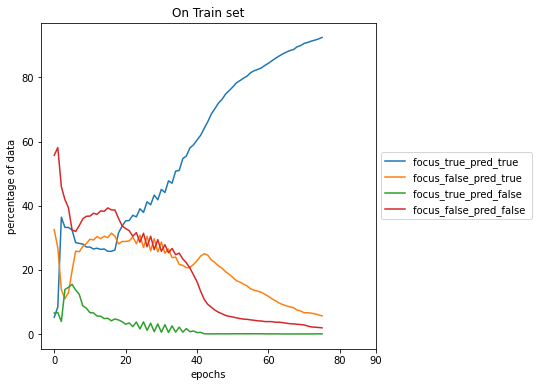

In [29]:
fig= plt.figure(figsize=(6,6))
plt.plot(df_train[columns[0]],df_train[columns[3]], label ="focus_true_pred_true ")
plt.plot(df_train[columns[0]],df_train[columns[4]], label ="focus_false_pred_true ")
plt.plot(df_train[columns[0]],df_train[columns[5]], label ="focus_true_pred_false ")
plt.plot(df_train[columns[0]],df_train[columns[6]], label ="focus_false_pred_false ")
plt.title("On Train set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("percentage of data")
plt.xticks([0,20,40,60,80,90])
#plt.vlines(vline_list,min(min(df_train[columns[3]]/300),min(df_train[columns[4]]/300),min(df_train[columns[5]]/300),min(df_train[columns[6]]/300)), max(max(df_train[columns[3]]/300),max(df_train[columns[4]]/300),max(df_train[columns[5]]/300),max(df_train[columns[6]]/300)),linestyles='dotted')
plt.show()
fig.savefig("train_analysis.pdf")
fig.savefig("train_analysis.png")

In [21]:
aph = []
for i in bg:
  aph.append(F.softmax(i,dim=1).detach().numpy())
aph = np.concatenate(aph,axis=0)
# torch.save({
#             'epoch': 500,
#             'model_state_dict': what_net.state_dict(),
#             #'optimizer_state_dict': optimizer_what.state_dict(),
#             "optimizer_alpha":optim1,
#             "FTPT_analysis":analysis_data_tr,
#             "alpha":aph

#             }, "type4_what_net_500.pt")

In [22]:
aph[0]

array([1.2738769e-11, 8.5432440e-08, 2.9385626e-07, 9.9999940e-01,
       2.9040422e-07, 4.9006759e-09, 3.0331612e-11, 2.8616909e-10,
       8.4814285e-13], dtype=float32)

In [23]:
xx,yy= np.meshgrid(np.arange(1,8,0.01),np.arange(2,9,0.01))
X = np.concatenate((xx.reshape(-1,1),yy.reshape(-1,1)),axis=1)
X = torch.Tensor(X).double().to("cuda")
Y1 = what_net(X)

In [24]:
Y1 = Y1.to("cpu")
Y1 = Y1.detach().numpy()
Y1 = torch.softmax(torch.Tensor(Y1),dim=1)
_,Z4= torch.max(Y1,1)
Z1 = Y1[:,0]
Z2 = Y1[:,1]
Z3 = Y1[:,2]

In [25]:
X = X.to("cpu")

In [26]:
data = np.load("type_4_data.npy",allow_pickle=True)
x = data[0]["X"]
y = data[0]["Y"]
idx= []
for i in range(10):
  print(i,sum(y==i))
  idx.append(y==i)

0 482
1 485
2 536
3 504
4 493
5 513
6 497
7 486
8 522
9 482


In [27]:
avrg = []
with torch.no_grad():
  for i, data in  enumerate(train_loader):
          inputs , labels , fore_idx = data
          inputs = inputs.double()
          inputs, labels = inputs.to("cuda"),labels.to("cuda")
          beta  = bg[i]
          beta = beta.to("cuda")
          avg,alpha = attn_avg(inputs,beta)
          
          avrg.append(avg.detach().cpu().numpy())
avrg= np.concatenate(avrg,axis=0)

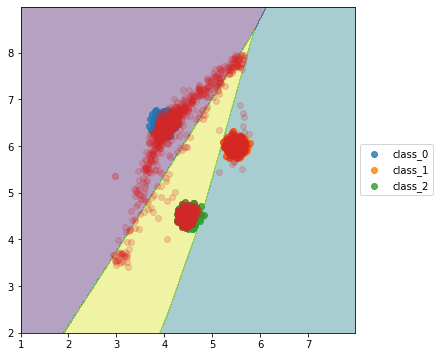

In [28]:
fig = plt.figure(figsize=(6,6))
#plt.scatter(X[:,0],X[:,1],c=Z4)
Z4 = Z4.reshape(xx.shape)
plt.contourf(xx, yy, Z4, alpha=0.4)
for i in range(3):
  plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i),alpha=0.8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.scatter(avrg[:,0],avrg[:,1],alpha=0.2)
plt.savefig("decision_boundary.png",bbox_inches="tight")
